In [1]:
from matplotlib.ticker import MaxNLocator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import os
import glob
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
cd drive/MyDrive/Colab\ Notebooks

In [ ]:
region = "Lambro_Olona"

In [ ]:
new_features_folder = "./new_features/"
csv_target = "./csv/" + region + ".csv"
classnames = ['Bad', 'Good']

In [ ]:
# take target values ultil the last useful date (cutting off 2020-2022)
from datetime import datetime

END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')
target = pd.read_csv(csv_target).rename(columns={'Unnamed: 0': 'date'})
target['date'] = pd.to_datetime(target['date'],format = '%Y-%m-%d')

# remove dates not available in features
target = target[target['date'] <= END_DATE]
target_df = target['mean'].to_frame()

In [ ]:
csv_features = glob.glob(new_features_folder + region + '*.csv')
csv_features

['./new_features/Lambro_Olona_nonLinCFA_CMI_train.csv',
 './new_features/Lambro_Olona_nonLinCFA_CMI_val.csv',
 './new_features/Lambro_Olona_nonLinCFA_wrapper_best5_test.csv',
 './new_features/Lambro_Olona_nonLinCFA_wrapper_best5_val.csv',
 './new_features/Lambro_Olona_nonLinCFA_best5_CMI_val.csv',
 './new_features/Lambro_Olona_nonLinCFA_best5_CMI_test.csv',
 './new_features/Lambro_Olona_nonLinCFA_best5_CMI_train.csv',
 './new_features/Lambro_Olona_nonLinCFA_wrapper_best5_train.csv',
 './new_features/Lambro_Olona_nonLinCFA_CMI_test.csv']

In [ ]:
# divide target into train/val/test sets

scaler_t = StandardScaler()

TRAIN_END_DATE = datetime.strptime('2009-12-31', '%Y-%m-%d')
VALID_END_DATE = datetime.strptime('2014-12-31', '%Y-%m-%d')
TEST_END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')

train_perc=0.475 # training data from 2001-01 to 2009-12 included, 411 samples
valid_perc = 0.2625 # 228 samples for valid and test sets
tot_rows = len(target_df)

target_train = target[target['date'] <= TRAIN_END_DATE]['mean'].to_frame()
# fit the scalers on training data
scaler_t.fit(target_train)
# scale all the dataset
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

target_train = target_df.iloc[0:round(tot_rows*train_perc)-1,:]
target_validation = target_df.iloc[round(tot_rows*train_perc)-1:round(tot_rows*(valid_perc+train_perc))]
target_test = target_df.iloc[round(tot_rows*(valid_perc+train_perc)):round(tot_rows*(valid_perc*2+train_perc))]

### Compute and plot quantiles

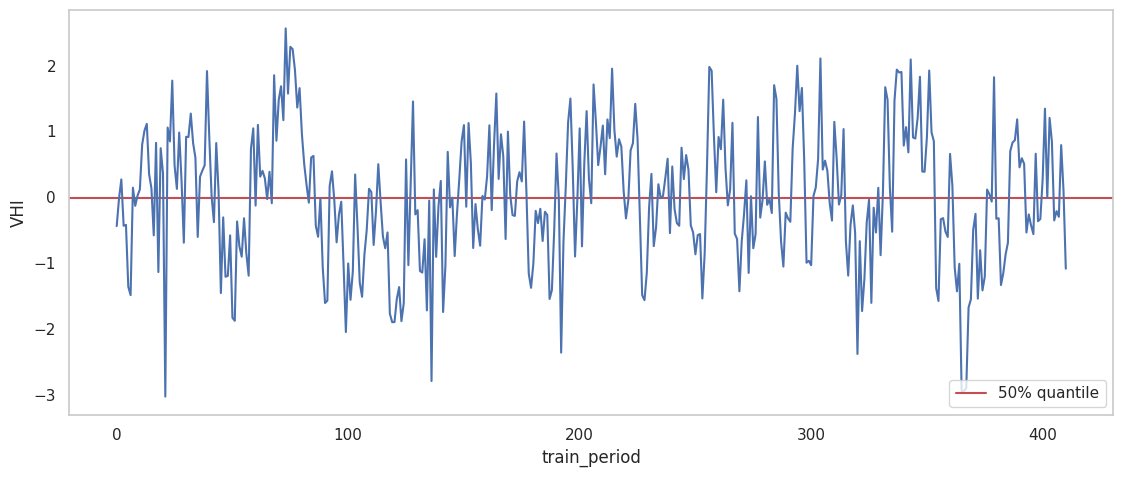

In [ ]:
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style("whitegrid", {'axes.grid' : False})

y_div = target_train['mean'].quantile(0.5)

plt.ylabel("VHI")
plt.xlabel("train_period")

plt.axhline(y_div, label='50% quantile', color = 'r')
plt.legend(loc="lower right")
plt.plot(target_train['mean'])

In [ ]:
# transform the target in 2 classes: 0 for bad, 1 for good

target_train['mean'] = target_train['mean'].apply(lambda x: 1 if x > y_div else 0)
target_validation['mean'] = target_validation['mean'].apply(lambda x: 1 if x > y_div else 0)
target_test['mean'] = target_test['mean'].apply(lambda x: 1 if x > y_div else 0)

<ipython-input-660-3fa7569c77a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_train['mean'] = target_train['mean'].apply(lambda x: 1 if x > y_div else 0)
<ipython-input-660-3fa7569c77a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_validation['mean'] = target_validation['mean'].apply(lambda x: 1 if x > y_div else 0)
<ipython-input-660-3fa7569c77a6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [ ]:
# see the number of instances for each class for test purpose and to check balance of class

np.unique(target_train['mean'], return_counts = True)

(array([0, 1]), array([206, 205]))

In [ ]:
y_train = target_train.values
y_validation = target_validation.values
y_test = target_test.values
y_train_validation = pd.concat([target_train, target_validation]).values

In [ ]:
def plot_conmat(true, pred, title, ax):
    conmat = confusion_matrix(true, pred, labels = [0, 1])
    val = np.mat(conmat)

    df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
        )
    
    group_counts = ["Count: {0:0.0f}".format(value) for value in
                df_cm.to_numpy().flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                      (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues', ax=ax)
    plt.rcParams["figure.figsize"] = (5,5)
    if title is not None : ax.set_title(title) 

In [ ]:
def feed_forward():
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(len(classnames), activation='softmax',name='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## NonLinCFA CMI best 5

In [ ]:
csv_path = new_features_folder + region + "_nonLinCFA_best5_CMI_"

In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()

features_train = pd.read_csv(csv_path + 'train.csv')
scaler_f.fit(features_train)

features_valid = pd.read_csv(csv_path + 'val.csv')
features_test = pd.read_csv(csv_path + 'test.csv')
features_valid[features_valid.columns] = scaler_f.transform(features_valid[features_valid.columns])
features_test[features_test.columns] = scaler_f.transform(features_test[features_test.columns])

features_train_validation = pd.concat([features_train, features_valid])

In [ ]:
idx_dic = {}
for col in features_train.columns:
    idx_dic[col] = features_train.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_tg_6
1: cyclostationary_mean_rr_4w_1
2: cyclostationary_mean_tg_0
3: cyclostationary_mean_tg_4w_6
4: cyclostationary_mean_tg_4w_5


In [ ]:
X_train = features_train.values
X_validation = features_valid.values
X_train_validation = features_train_validation.values
X_test = features_test.values

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

log_regr.fit(X_train_validation, y_train_validation.ravel())
print("Test accuracy logistic regression: ", round(log_regr.score(X_test, y_test),3))
print("Train accuracy logistic regression: ", round(log_regr.score(X_train_validation, y_train_validation),3))

Test accuracy logistic regression:  0.724
Train accuracy logistic regression:  0.671


<ipython-input-663-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


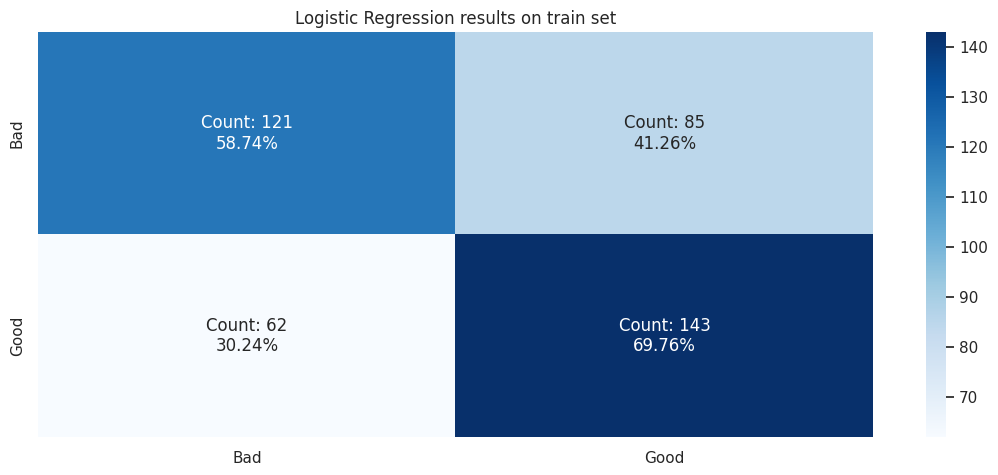

In [ ]:
fig,ax=plt.subplots()
plot_conmat(y_train, log_regr.predict(X_train), 'Logistic Regression results on train set', ax=ax)

<ipython-input-663-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


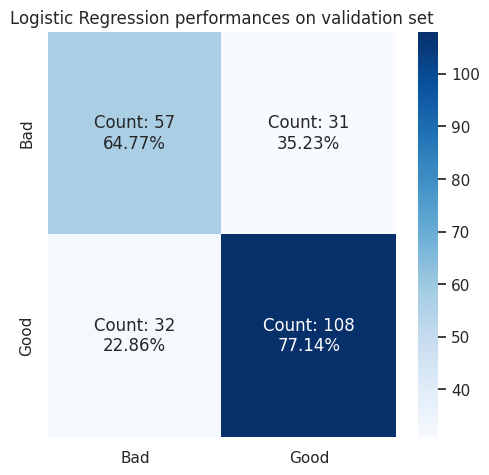

In [ ]:
fig,ax=plt.subplots()
plot_conmat(y_validation, log_regr.predict(X_validation), 'Logistic Regression performances on validation set', ax=ax)

<ipython-input-663-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


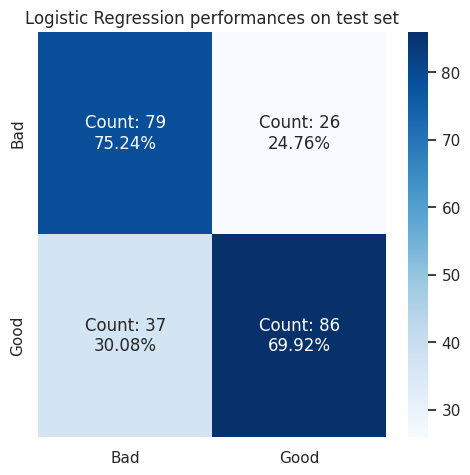

In [ ]:
fig,ax=plt.subplots()
plot_conmat(y_test, log_regr.predict(X_test), 'Logistic Regression performances on test set', ax=ax)

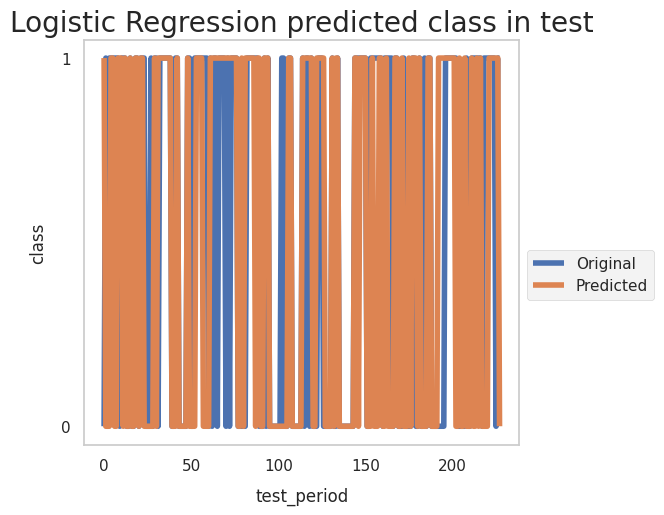

In [ ]:
fig, ax= plt.subplots()
plt.style.use('fivethirtyeight')
#y_test.reset_index(inplace = True, drop = True)
plt.plot(y_test, label='Original')
plt.title('Logistic Regression predicted class in test')
plt.plot(log_regr.predict(X_test), label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('test_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Extra Trees Classifier

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 220, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 10, 25, 50, 100]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }

In [ ]:
from sklearn.model_selection import GridSearchCV

ext = ExtraTreesClassifier(random_state=42)

opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 3)

# GridSearchCV already does 5-fold cross validation by default,
# so I take both train and validation data
opt.fit(X_train_validation, y_train_validation.ravel())

In [ ]:
opt.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_split': 100,
 'n_estimators': 35}

In [ ]:
rfc= ExtraTreesClassifier(random_state=42, max_features = 'auto', min_samples_split = 100, n_estimators = 35, bootstrap = 'True')
rfc.fit(X_train_validation, y_train_validation.ravel())

ExtraTreesClassifier(bootstrap='True', min_samples_split=100, n_estimators=35,
                     random_state=42)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
rf_mae = mean_absolute_error(y_test, rfc.predict(X_test))
rf_mse = mean_squared_error(y_test, rfc.predict(X_test))
r2_test = rfc.score(X_test, y_test)
r2_train = rfc.score(X_train_validation, y_train_validation)

print(" ExtraTreesClassifier: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","acc_test: ",round(r2_test,3), "\n", "acc_train: ", round(r2_train,3))

 ExtraTreesClassifier: 
 MAE:  0.237 
 MSE:  0.237 
 acc_test:  0.763 
 acc_train:  0.731


In [ ]:
# Get numerical feature importances
importances = list(rfc.feature_importances_)
feature_list = list(features_train.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: cyclostationary_mean_tg_4 Importance: 0.3
Variable: cyclostationary_mean_rr_4w_3 Importance: 0.21
Variable: cyclostationary_mean_rr_12w_1 Importance: 0.18
Variable: cyclostationary_mean_tg_1w_4 Importance: 0.16
Variable: cyclostationary_mean_rr_8w_0 Importance: 0.14


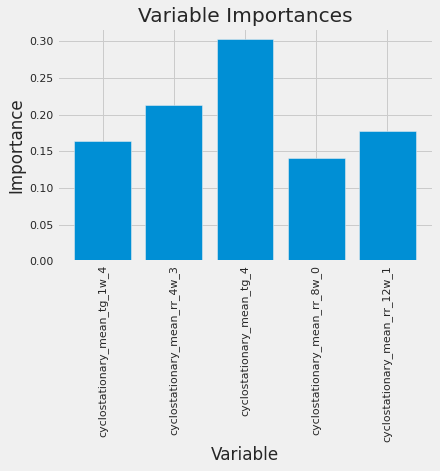

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

<ipython-input-27-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


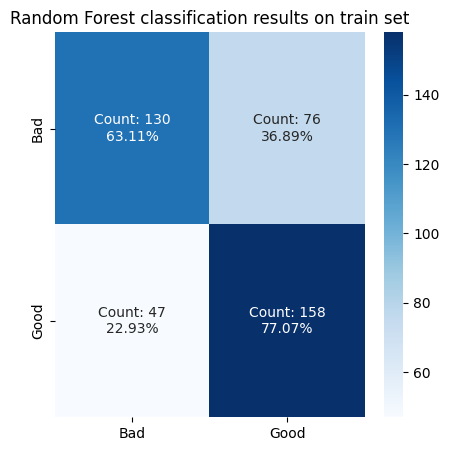

In [ ]:
fig,ax=plt.subplots()
plt.style.use('default')
plot_conmat(y_train, rfc.predict(X_train), 'Random Forest classification results on train set', ax=ax)

<ipython-input-27-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


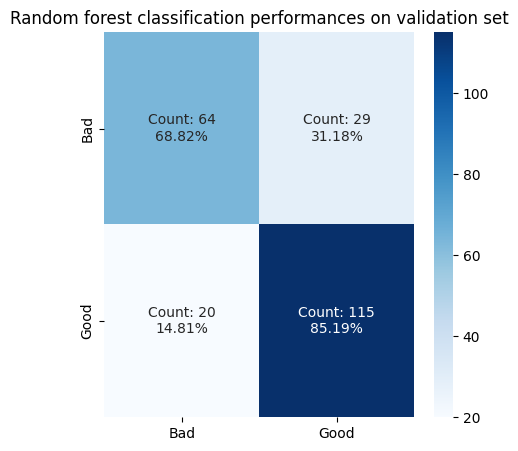

In [ ]:
fig,ax=plt.subplots()
plot_conmat(y_validation, rfc.predict(X_validation), 'Random forest classification performances on validation set', ax=ax)

<ipython-input-27-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


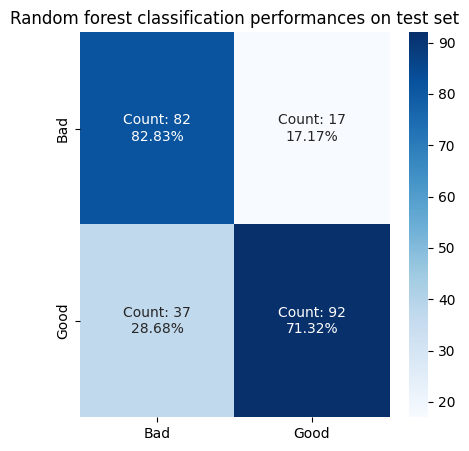

In [ ]:
fig, ax = plt.subplots()
plt.style.use('default')
plot_conmat(y_test, rfc.predict(X_test), 'Random forest classification performances on test set', ax=ax)
plt.savefig('random_forest_classification_singletask.eps', format='eps')

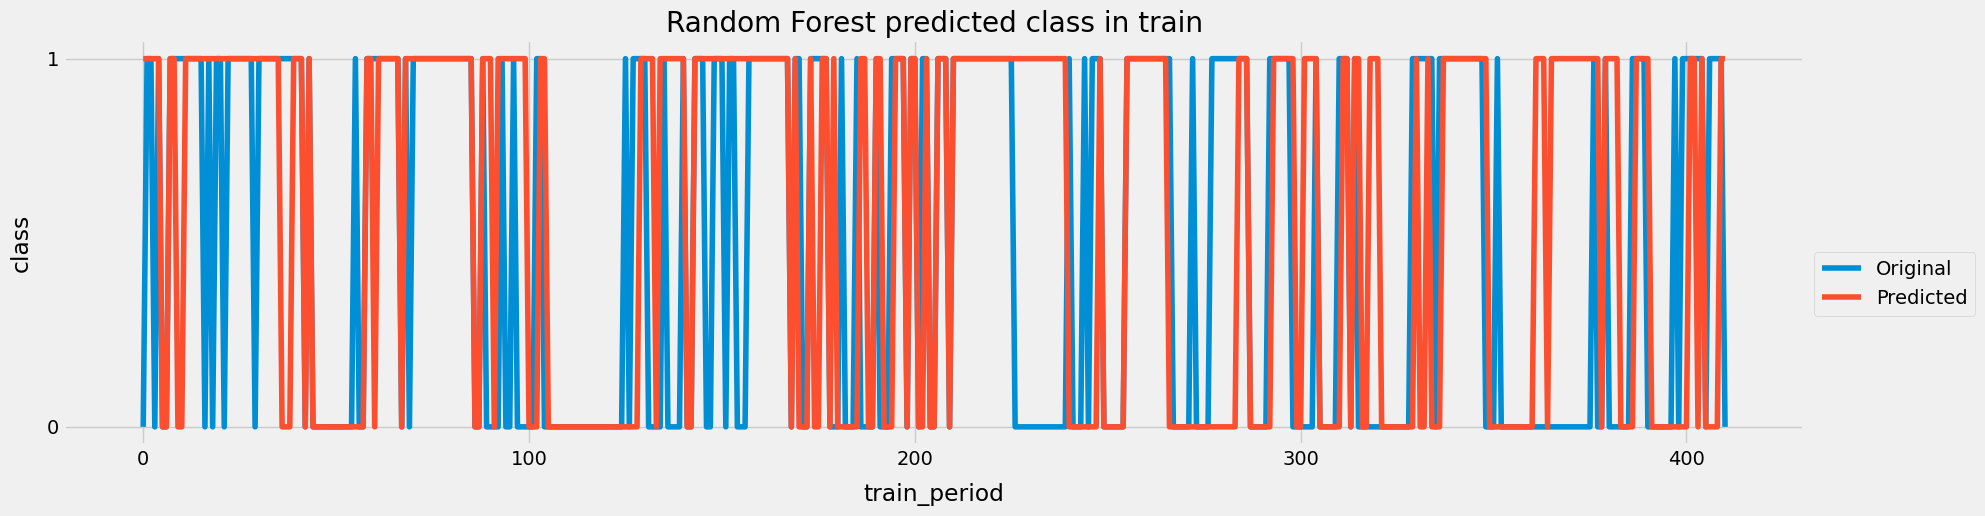

In [ ]:
fig, ax= plt.subplots()
plt.style.use('fivethirtyeight')
plt.plot(y_train, label='Original')
plt.title('Random Forest predicted class in train')
plt.plot(rfc.predict(X_train), label='Predicted')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('train_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

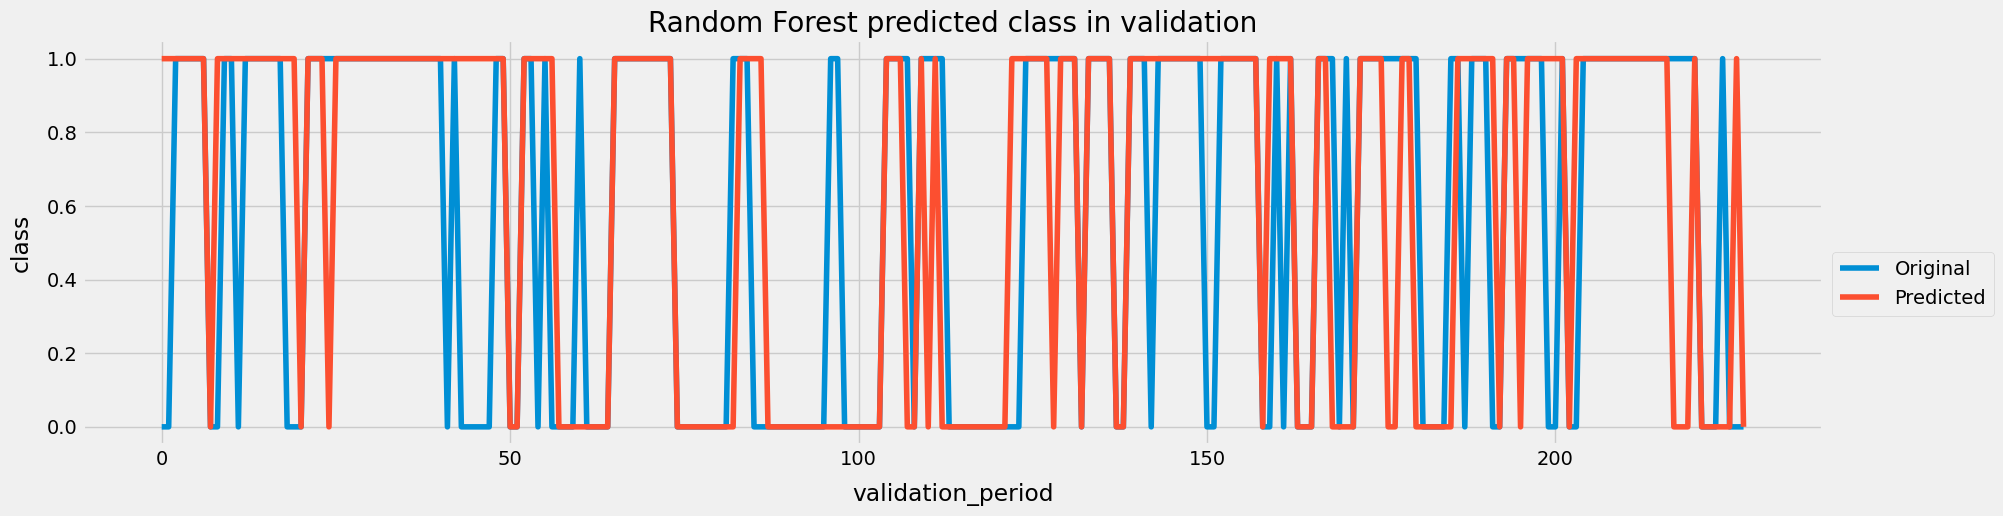

In [ ]:
plt.plot(y_validation, label='Original')
plt.style.use('fivethirtyeight')
plt.title('Random Forest predicted class in validation')
plt.plot(rfc.predict(X_validation), label='Predicted')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('validation_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

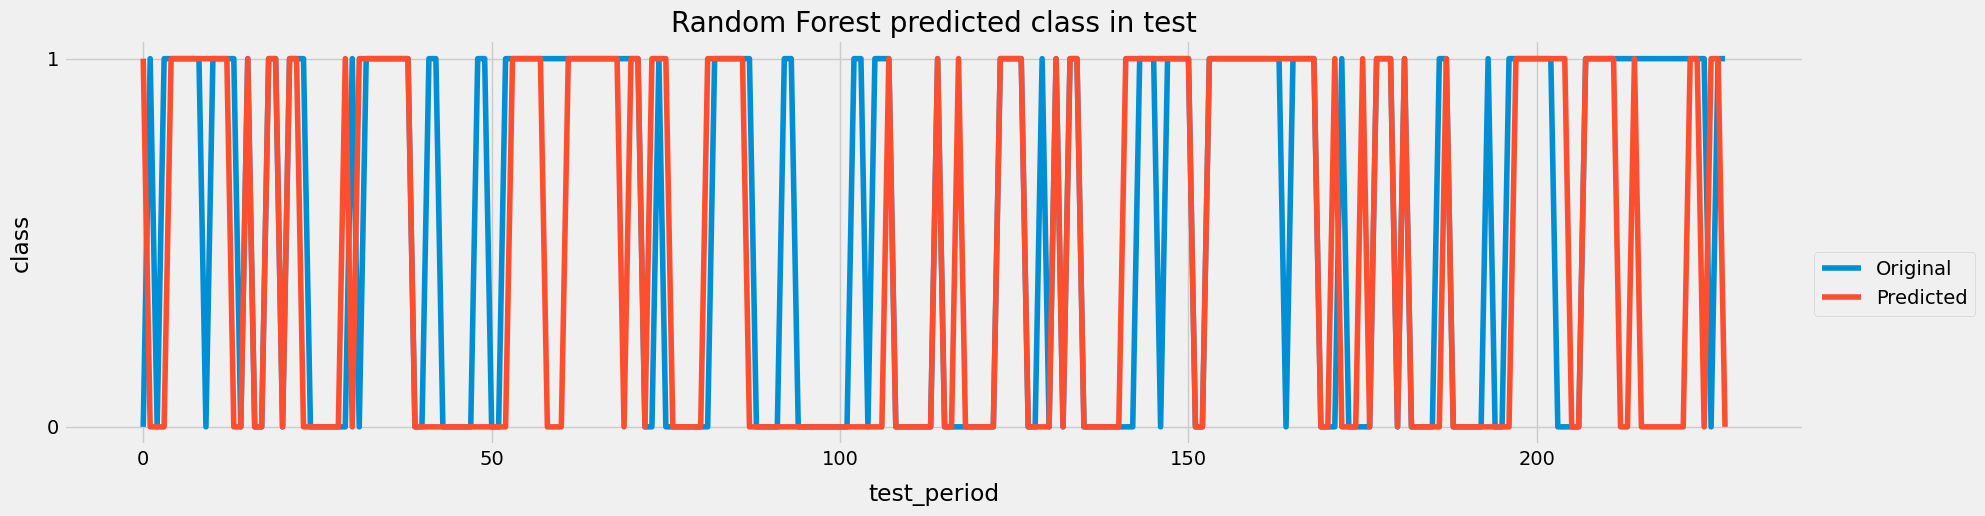

In [ ]:
fig, ax= plt.subplots()
plt.style.use('fivethirtyeight')
#y_test.reset_index(inplace = True, drop = True)
plt.plot(y_test, label='Original')
plt.title('Random Forest predicted class in test')
plt.plot(rfc.predict(X_test), label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('test_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Feed Forward

In [ ]:
# 10 for 0(bad), 01 for 1 (good)
y_train_ffnn = np.eye(2)[target_train['mean']]
y_validation_ffnn = np.eye(2)[target_validation['mean']]
y_test_ffnn = np.eye(2)[target_test['mean']]

In [ ]:
tuning_model = feed_forward()

history = tuning_model.fit(X_train, y_train_ffnn, validation_data = (X_validation, y_validation_ffnn), shuffle=False, epochs=1000, verbose=0)

KeyboardInterrupt: ignored

Text(0, 0.5, 'loss')

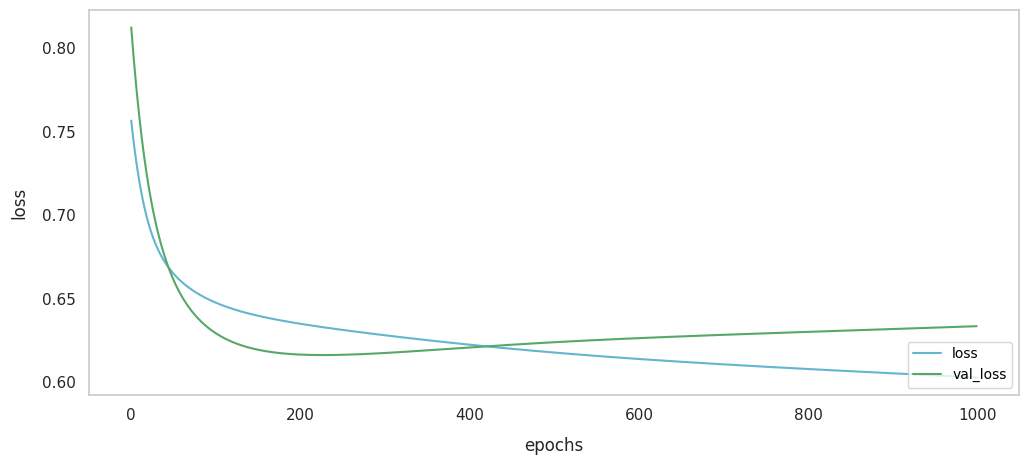

In [ ]:
plt.plot(history.history['loss'], 'c', label= "loss")
plt.plot(history.history['val_loss'],'g', label= "val_loss")
plt.style.use('default')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15,5)

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [ ]:
y_train_val_ffnn = np.concatenate((y_train_ffnn, y_validation_ffnn))

model = feed_forward()
tmp = model.fit(X_train_validation, y_train_val_ffnn, shuffle=False, epochs=80, verbose=0)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4)                 24        
                                                                 
 softmax (Dense)             (None, 2)                 10        
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("FFNN:")
print("      ",model.metrics_names)
print("test: ", np.around(model.evaluate(X_test,y_test_ffnn, verbose = 0),3))
print("train: ", np.around(model.evaluate(X_train_validation,y_train_val_ffnn, verbose = 0),3))

FFNN:
       ['loss', 'accuracy']
test:  [0.578 0.728]
train:  [0.575 0.731]


13/13 [==============================] - 0s 2ms/step


<ipython-input-13-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


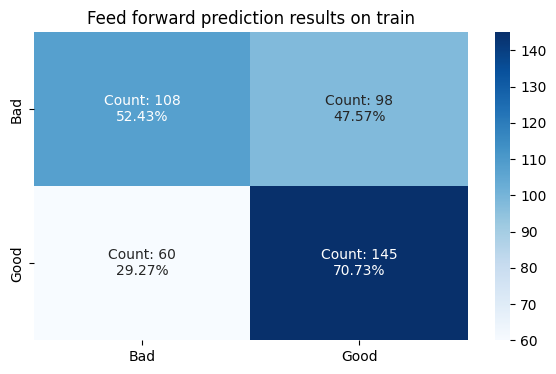

In [ ]:
fig,ax = plt.subplots(figsize=(7,4))
plot_conmat(y_train_ffnn.argmax(axis=1), model.predict(X_train).argmax(axis=1), 'Feed forward prediction results on train', ax=ax)

8/8 [==============================] - 0s 6ms/step


<ipython-input-13-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


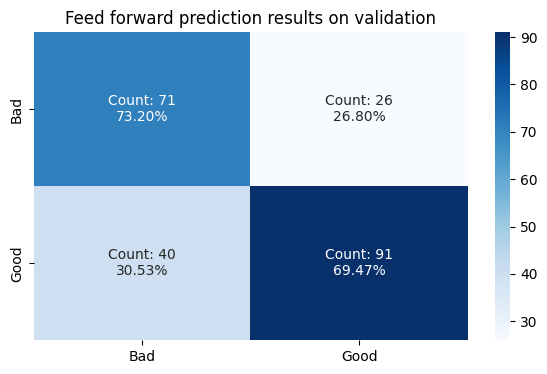

In [ ]:
fig,ax = plt.subplots(figsize=(7,4))
plot_conmat(y_validation_ffnn.argmax(axis=1), model.predict(X_validation).argmax(axis=1), 'Feed forward prediction results on validation', ax=ax)

8/8 [==============================] - 0s 2ms/step


<ipython-input-13-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


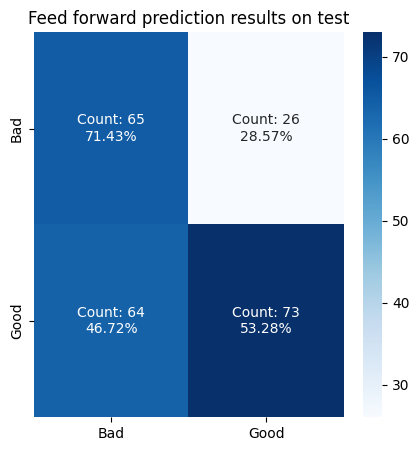

In [ ]:
fig, ax = plt.subplots()
plot_conmat(y_test_ffnn.argmax(axis=1), model.predict(X_test).argmax(axis=1), 'Feed forward prediction results on test', ax=ax)

In [ ]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots()
plt.plot(list(map(lambda x: 0 if x==0 else 1, y_train_ffnn.argmax(axis=1))), label='Original')
plt.title('Feed forward predicted class in train')
plt.plot(list(map(lambda x: 0 if x==0 else 1, model.predict(X_train).argmax(axis=1))), label='Predicted')

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('train_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
plt.legend()
plt.show()

In [ ]:
plt.plot(list(map(lambda x: 0 if x==0 else 1, y_validation_ffnn.argmax(axis=1))), label='Original')
plt.title('Feed forward predicted class in validation')
plt.plot(list(map(lambda x: 0 if x==0 else 1, model.predict(X_validation).argmax(axis=1))), label='Predicted')
plt.legend()
plt.show()

In [ ]:
trues_test = list(map(lambda x: 0 if x==0 else 1, y_test_ffnn.argmax(axis=1)))
preds = list(map(lambda x: 0 if x==0 else 1, model.predict(X_test).argmax(axis=1)))

In [ ]:
fig, ax = plt.subplots()
plt.plot(trues_test, label='Original')
plt.title('Feed forward predicted class in test')
plt.plot(preds, label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('test_period', labelpad=10)
plt.ylabel('class', labelpad=10)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

## NonLinCFA CMI all

In [ ]:
csv_path = new_features_folder + region + "_nonLinCFA_CMI_"

In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()

features_train = pd.read_csv(csv_path + 'train.csv')
scaler_f.fit(features_train)

features_valid = pd.read_csv(csv_path + 'val.csv')
features_test = pd.read_csv(csv_path + 'test.csv')
features_valid[features_valid.columns] = scaler_f.transform(features_valid[features_valid.columns])
features_test[features_test.columns] = scaler_f.transform(features_test[features_test.columns])

features_train_validation = pd.concat([features_train, features_valid])

In [ ]:
idx_dic = {}
for col in features_train.columns:
    idx_dic[col] = features_train.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_tg_6
1: cyclostationary_mean_rr_4w_1
2: cyclostationary_mean_tg_0
3: cyclostationary_mean_tg_4w_6
4: cyclostationary_mean_tg_4w_5


In [ ]:
X_train = features_train.values
X_validation = features_valid.values
X_train_validation = features_train_validation.values
X_test = features_test.values

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression(solver='lbfgs', random_state = 42, max_iter = 200)

log_regr.fit(X_train_validation, y_train_validation.ravel())
print("Test accuracy logistic regression: ", round(log_regr.score(X_test, y_test),3))
print("Train accuracy logistic regression: ", round(log_regr.score(X_train_validation, y_train_validation),3))

Test accuracy logistic regression:  0.746
Train accuracy logistic regression:  0.718


<ipython-input-456-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


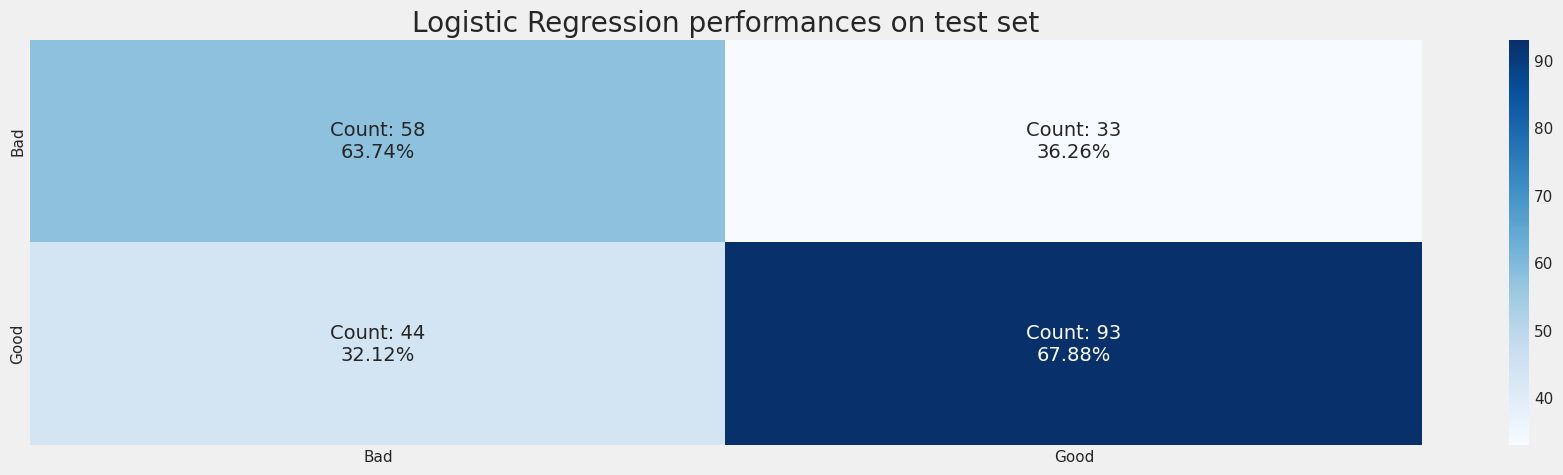

In [ ]:
fig,ax=plt.subplots()
plot_conmat(y_test, log_regr.predict(X_test), 'Logistic Regression performances on test set', ax=ax)

### Extra Trees Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV

ext = ExtraTreesClassifier(random_state=42)

opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 3)

# GridSearchCV already does 5-fold cross validation by default,
# so I take both train and validation data
opt.fit(X_train_validation, y_train_validation.ravel())

In [ ]:
opt.best_params_

{'bootstrap': False,
 'max_features': 'auto',
 'min_samples_split': 100,
 'n_estimators': 78}

In [ ]:
rfc= ExtraTreesClassifier(random_state=42, max_features = 'auto', min_samples_split = 100, n_estimators = 78, bootstrap = 'False')
rfc.fit(X_train_validation, y_train_validation.ravel())

ExtraTreesClassifier(bootstrap='False', min_samples_split=100, n_estimators=78,
                     random_state=42)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
rf_mae = mean_absolute_error(y_test, rfc.predict(X_test))
rf_mse = mean_squared_error(y_test, rfc.predict(X_test))
r2_test = rfc.score(X_test, y_test)
r2_train = rfc.score(X_train_validation, y_train_validation)

print(" ExtraTreesClassifier: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","acc_test: ",round(r2_test,3), "\n", "acc_train: ", round(r2_train,3))

 ExtraTreesClassifier: 
 MAE:  0.237 
 MSE:  0.237 
 acc_test:  0.763 
 acc_train:  0.721


In [ ]:
# Get numerical feature importances
importances = list(rfc.feature_importances_)
feature_list = list(features_train.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: cyclostationary_mean_tg_4 Importance: 0.2
Variable: cyclostationary_mean_rr_4w_3 Importance: 0.15
Variable: cyclostationary_mean_tg_1w_3 Importance: 0.14
Variable: cyclostationary_mean_rr_12w_1 Importance: 0.1
Variable: cyclostationary_mean_tg_1w_4 Importance: 0.09
Variable: cyclostationary_mean_rr_8w_0 Importance: 0.09
Variable: cyclostationary_mean_rr_8w_2 Importance: 0.07
Variable: cyclostationary_mean_rr_12w_0 Importance: 0.05
Variable: cyclostationary_mean_rr_16w_2 Importance: 0.04
Variable: cyclostationary_mean_rr_16w_1 Importance: 0.03
Variable: cyclostationary_mean_tg_8w_0 Importance: 0.02
Variable: cyclostationary_mean_tg_8w_3 Importance: 0.01


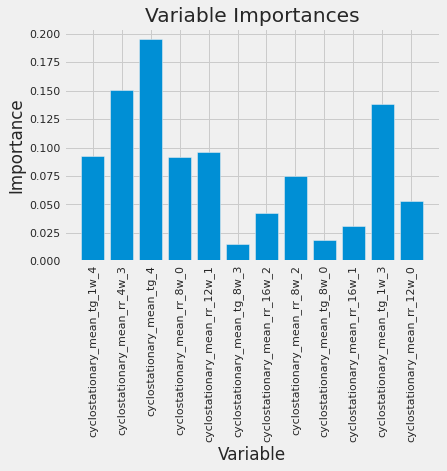

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

<ipython-input-12-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


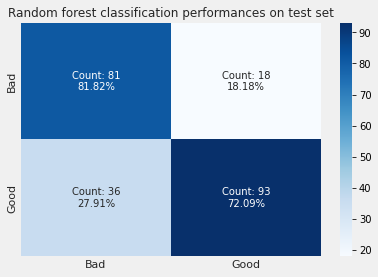

In [ ]:
fig, ax = plt.subplots()
plt.style.use('default')
plot_conmat(y_test, rfc.predict(X_test), 'Random forest classification performances on test set', ax=ax)
plt.savefig('random_forest_classification_singletask.eps', format='eps')

### Feed Forward

In [ ]:
# 10 for 0(bad), 01 for 1 (good)
y_train_ffnn = np.eye(2)[target_train['mean']]
y_validation_ffnn = np.eye(2)[target_validation['mean']]
y_test_ffnn = np.eye(2)[target_test['mean']]

In [ ]:
tuning_model = feed_forward()

history = tuning_model.fit(X_train, y_train_ffnn, validation_data = (X_validation, y_validation_ffnn), shuffle=False, epochs=1000, verbose=0)

KeyboardInterrupt: ignored

Text(0, 0.5, 'loss')

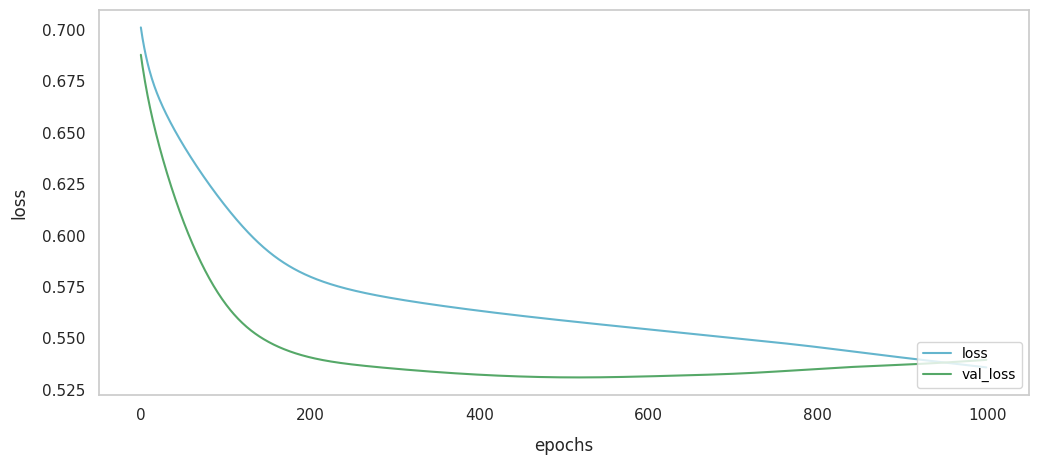

In [ ]:
plt.plot(history.history['loss'], 'c', label= "loss")
plt.plot(history.history['val_loss'],'g', label= "val_loss")
plt.style.use('default')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15,5)

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [ ]:
y_train_val_ffnn = np.concatenate((y_train_ffnn, y_validation_ffnn))

model = feed_forward()
tmp = model.fit(X_train_validation, y_train_val_ffnn, shuffle=False, epochs=200, verbose=0)

In [ ]:
print("FFNN:") 
print("      ",model.metrics_names)
print("test: ", np.around(model.evaluate(X_test,y_test_ffnn, verbose = 0),3))
print("train: ", np.around(model.evaluate(X_train_validation,y_train_val_ffnn, verbose = 0),3))

FFNN:
       ['loss', 'accuracy']
test:  [0.675 0.61 ]
train:  [0.681 0.552]


## NonLinCFA wrapper best 5

In [ ]:
csv_path = new_features_folder + region +"_nonLinCFA_wrapper_best5_"

In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()

features_train = pd.read_csv(csv_path + 'train.csv')
scaler_f.fit(features_train)

features_valid = pd.read_csv(csv_path + 'val.csv')
features_test = pd.read_csv(csv_path + 'test.csv')
features_valid[features_valid.columns] = scaler_f.transform(features_valid[features_valid.columns])
features_test[features_test.columns] = scaler_f.transform(features_test[features_test.columns])

features_train_validation = pd.concat([features_train, features_valid])

In [ ]:
idx_dic = {}
for col in features_train.columns:
    idx_dic[col] = features_train.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_tg_1w_2
1: cyclostationary_mean_rr_1w_1
2: cyclostationary_mean_tg_1w_5
3: cyclostationary_mean_tg_1w_4
4: cyclostationary_mean_tg_24w_1


In [ ]:
X_train = features_train.values
X_validation = features_valid.values
X_train_validation = features_train_validation.values
X_test = features_test.values

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression(solver='lbfgs', random_state = 42, max_iter = 200)

log_regr.fit(X_train_validation, y_train_validation.ravel())
print("Test accuracy logistic regression: ", round(log_regr.score(X_test, y_test),3))
print("Train accuracy logistic regression: ", round(log_regr.score(X_train_validation, y_train_validation),3))

Test accuracy logistic regression:  0.693
Train accuracy logistic regression:  0.676


### Extra Trees Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV

ext = ExtraTreesClassifier(random_state=42)

opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 3)

# GridSearchCV already does 5-fold cross validation by default,
# so I take both train and validation data
opt.fit(X_train_validation, y_train_validation.ravel())

Streaming output truncated to the last 5000 lines.
[CV 1/5] END bootstrap=True, max_features=sqrt, min_samples_split=3, n_estimators=10;, score=0.594 total time=   0.0s
[CV 2/5] END bootstrap=True, max_features=sqrt, min_samples_split=3, n_estimators=10;, score=0.539 total time=   0.0s
[CV 3/5] END bootstrap=True, max_features=sqrt, min_samples_split=3, n_estimators=10;, score=0.531 total time=   0.0s
[CV 4/5] END bootstrap=True, max_features=sqrt, min_samples_split=3, n_estimators=10;, score=0.609 total time=   0.0s
[CV 5/5] END bootstrap=True, max_features=sqrt, min_samples_split=3, n_estimators=10;, score=0.669 total time=   0.0s
[CV 1/5] END bootstrap=True, max_features=sqrt, min_samples_split=3, n_estimators=14;, score=0.633 total time=   0.0s
[CV 2/5] END bootstrap=True, max_features=sqrt, min_samples_split=3, n_estimators=14;, score=0.555 total time=   0.0s
[CV 3/5] END bootstrap=True, max_features=sqrt, min_samples_split=3, n_estimators=14;, score=0.516 total time=   0.0s
[CV 4

GridSearchCV(estimator=ExtraTreesClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_split': [2, 3, 5, 10, 25, 50, 100],
                         'n_estimators': [10, 14, 18, 22, 27, 31, 35, 40, 44,
                                          48, 52, 57, 61, 65, 70, 74, 78, 82,
                                          87, 91, 95, 100, 104, 108, 112, 117,
                                          121, 125, 130, 134, ...]},
             verbose=3)

In [ ]:
opt.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_split': 100,
 'n_estimators': 14}

In [ ]:
rfc= ExtraTreesClassifier(random_state=42, max_features = 'auto', min_samples_split = 100, n_estimators = 35, bootstrap = 'True')
rfc.fit(X_train_validation, y_train_validation.ravel())

ExtraTreesClassifier(bootstrap='True', min_samples_split=100, n_estimators=35,
                     random_state=42)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
rf_mae = mean_absolute_error(y_test, rfc.predict(X_test))
rf_mse = mean_squared_error(y_test, rfc.predict(X_test))
r2_test = rfc.score(X_test, y_test)
r2_train = rfc.score(X_train_validation, y_train_validation)

print(" ExtraTreesClassifier: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","acc_test: ",round(r2_test,3), "\n", "acc_train: ", round(r2_train,3))

 ExtraTreesClassifier: 
 MAE:  0.206 
 MSE:  0.206 
 acc_test:  0.794 
 acc_train:  0.695


### Feed Forward

In [ ]:
# 10 for 0(bad), 01 for 1 (good)
y_train_ffnn = np.eye(2)[target_train['mean']]
y_validation_ffnn = np.eye(2)[target_validation['mean']]
y_test_ffnn = np.eye(2)[target_test['mean']]

In [ ]:
tuning_model = feed_forward()

history = tuning_model.fit(X_train, y_train_ffnn, validation_data = (X_validation, y_validation_ffnn), shuffle=False, epochs=1000, verbose=0)

Text(0, 0.5, 'loss')

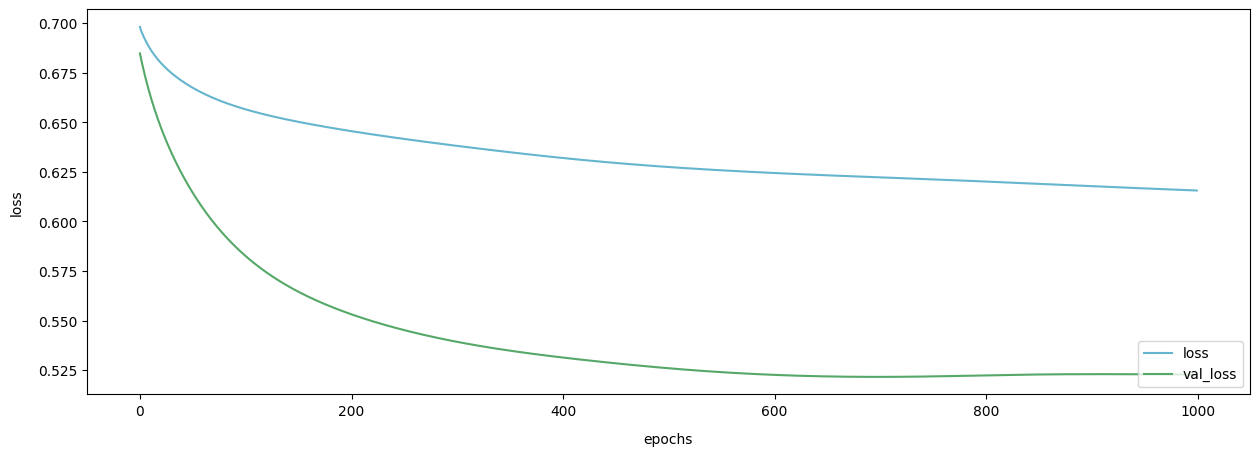

In [ ]:
plt.plot(history.history['loss'], 'c', label= "loss")
plt.plot(history.history['val_loss'],'g', label= "val_loss")
plt.style.use('default')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15,5)

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [ ]:
y_train_val_ffnn = np.concatenate((y_train_ffnn, y_validation_ffnn))

model = feed_forward()
tmp = model.fit(X_train_validation, y_train_val_ffnn, shuffle=False, epochs=250, verbose=0)

In [ ]:
print("FFNN:")
print("      ",model.metrics_names)
print("test: ", np.around(model.evaluate(X_test, y_test_ffnn, verbose = 0),3))
print("train: ", np.around(model.evaluate(X_train_validation, y_train_val_ffnn, verbose = 0),3))

FFNN:
       ['loss', 'accuracy']
test:  [0.529 0.803]
train:  [0.587 0.679]
